In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json

### The following cells show the result of pose estimation based on different image resolution. 

Basically, the image resolutions are ranging from 80x80 to 496x496, all multiples of 16.

The result data is located in folder 'step1'

In [3]:
col_info = ['model', 'cocoyear', 'resolution', 'time_elapsed',
            'AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5']
df = pd.DataFrame(columns=col_info)

In [4]:
for model in ['cmu', 'mobilenet_thin', 'mobilenet_v2_large']:
    for i in range(5,32):
        res = i*16
        if res==448 or res==480: #I didn't run pose estimation model on resolution of 448x448 and 480x480
            continue
        resolution = str(res)+'x'+str(res)
        filename = './step1/%s_%s_2017_8.0_pr.json' % (model, resolution)
        
        with open(filename) as f:
            data = f.readline()
            data = data.split('"')
            time_elapsed = float(data[2])
            precision_and_recall = []
            temp = data[1].split()
            for item in temp:
                if item != '|':
                    precision_and_recall.append(float(item))
            df = df.append(pd.Series([model, 2017, res, time_elapsed,
                                      precision_and_recall[0],
                                      precision_and_recall[1],
                                      precision_and_recall[2],
                                      precision_and_recall[3],
                                      precision_and_recall[4],
                                      precision_and_recall[5],
                                      precision_and_recall[6],
                                      precision_and_recall[7],
                                      precision_and_recall[8],
                                      precision_and_recall[9]], index=df.columns), ignore_index=True)

df
        

,model,cocoyear,resolution,time_elapsed,AP1,AP2,AP3,AP4,AP5,AR1,AR2,AR3,AR4,AR5
0,cmu,2017,80,99.383285,0.0511,0.1268,0.0335,0.0013,0.1154,0.0671,0.1488,0.0527,0.0002,0.1583
1,cmu,2017,96,161.264297,0.0762,0.1711,0.0577,0.0029,0.1725,0.0986,0.1977,0.0897,0.0019,0.2301
2,cmu,2017,112,166.222250,0.0995,0.2145,0.0845,0.0077,0.2222,0.1279,0.2407,0.1209,0.0062,0.2936
3,cmu,2017,128,170.818202,0.1226,0.2505,0.1092,0.0120,0.2701,0.1564,0.2834,0.1500,0.0123,0.3524
4,cmu,2017,144,178.813305,0.1441,0.2851,0.1269,0.0195,0.3120,0.1836,0.3212,0.1773,0.0218,0.4038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,mobilenet_v2_large,2017,400,122.921294,0.2687,0.4846,0.2575,0.1834,0.3929,0.3037,0.5025,0.3040,0.1855,0.4666
71,mobilenet_v2_large,2017,416,132.647169,0.2743,0.4940,0.2617,0.1937,0.3919,0.3127,0.5167,0.3116,0.1994,0.4684
72,mobilenet_v2_large,2017,432,140.853214,0.2773,0.5031,0.2579,0.2071,0.3818,0.3150,0.5222,0.3089,0.2113,0.4579
73,mobilenet_v2_large,2017,464,159.171811,0.2922,0.5316,0.2734,0.2364,0.3780,0.3339,0.5540,0.3297,0.2409,0.4621


In [5]:
#Showing the result only for cmu models
df_cmu = df.loc[df['model']=='cmu']

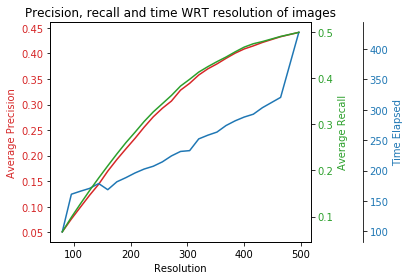

<Figure size 6000x2000 with 0 Axes>

The unit of 'Time elapsed' is second.


In [6]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_title('Precision, recall and time WRT resolution of images')
ax1.set_xlabel('Resolution')
ax1.set_ylabel('Average Precision', color=color)
ax1.plot(df_cmu['resolution'], df_cmu['AP1'], color=color) # Here I only plot the first Average Precision
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Time Elapsed', color=color)
ax2.plot(df_cmu['resolution'], df_cmu['time_elapsed'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines["right"].set_position(("axes", 1.2))

ax3 = ax1.twinx()
color = 'tab:green'
ax3.set_ylabel('Average Recall', color=color)
ax3.plot(df_cmu['resolution'], df_cmu['AR1'], color=color) # here I only plot the first Average Recall
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.figure(figsize=[30,10],dpi=200)
plt.show()

print('The unit of \'Time elapsed\' is second.')

### Next Step: Running face detection on the COCO Dataset.

The model has a parameter called `number_of_times_to_upsample` – It determines how many times to upsample the image looking for faces. Higher numbers find smaller faces. I can only run the model with maximum `number_of_times_to_upsample` of 2. If higher, it will report a "out of memory" error.

Since the upsample can only be 0, 1, or 2, I hardcoded the result in the following cell.

The result data is in the folder 'step2'

In [7]:
#face_detected: how many faces does the model detect after running through the dataset
face_detected = [537,1372,2487]
time_consumed = [27.789, 94.746, 355.008]
upsample = [0,1,2]


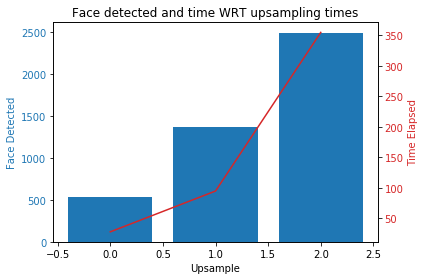

<Figure size 6000x2000 with 0 Axes>

The unit of 'Time elapsed' is second.


In [8]:
#Plotting the data
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_title('Face detected and time WRT upsampling times')
ax1.set_xlabel('Upsample')
ax1.set_ylabel('Face Detected', color=color)
ax1.bar(upsample, face_detected, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Time Elapsed', color=color)
ax2.plot(upsample, time_consumed, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.figure(figsize=[30,10],dpi=200)
plt.show()

print('The unit of \'Time elapsed\' is second.')

### Next Step: Blur the faces in the dataset using Gaussian Blur. Then run pose estimation again on blurred dataset.

The Gaussian Blur algorithm has a parameter called `radius`, the higher the value, the more the image is blurred

The following cells show the result of pose estimation on datasets that are blurred with different `radius` value(ranging from 1 to 15).

The pose estimation model used here is cmu model, with resolution of 432x368, which is the default resolution.

The result data is located in folder 'step3'

In [9]:
col_info_2 = ['blur_radius', 'time_elapsed', 'AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5']
df2 = pd.DataFrame(columns=col_info_2)
for i in range(1,16):
    filename = './step3/cmu_0x0_2_%s_pr.json' % str(i)
    with open(filename) as f:
        data = f.readline()
        data = data.split('"')
        time_elapsed = float(data[2])
        precision_and_recall = []
        temp = data[1].split()
        for item in temp:
            if item != '|':
                precision_and_recall.append(float(item))
        df2 = df2.append(pd.Series([i, time_elapsed,
                                    precision_and_recall[0],
                                    precision_and_recall[1],
                                    precision_and_recall[2],
                                    precision_and_recall[3],
                                    precision_and_recall[4],
                                    precision_and_recall[5],
                                    precision_and_recall[6],
                                    precision_and_recall[7],
                                    precision_and_recall[8],
                                    precision_and_recall[9]], index=df2.columns), ignore_index=True)
df2

,blur_radius,time_elapsed,AP1,AP2,AP3,AP4,AP5,AR1,AR2,AR3,AR4,AR5
0,1.0,534.634475,0.4794,0.7446,0.4996,0.4593,0.5036,0.5396,0.7683,0.5636,0.4735,0.6347
1,2.0,416.876951,0.4590,0.7336,0.4750,0.4380,0.4879,0.5205,0.7546,0.5422,0.4492,0.6223
2,3.0,416.887836,0.4338,0.7223,0.4397,0.4150,0.4568,0.4976,0.7435,0.5137,0.4267,0.5986
3,4.0,417.604133,0.4185,0.7110,0.4179,0.4062,0.4273,0.4817,0.7333,0.4943,0.4170,0.5736
4,5.0,427.167070,0.4072,0.7009,0.4044,0.4021,0.4064,0.4708,0.7258,0.4814,0.4129,0.5528
5,6.0,433.241194,0.4014,0.6993,0.3951,0.4003,0.3924,0.4638,0.7207,0.4739,0.4110,0.5388
6,7.0,431.255104,0.3970,0.6908,0.3869,0.4003,0.3843,0.4595,0.7179,0.4665,0.4111,0.5283
7,8.0,428.697174,0.3945,0.6899,0.3868,0.4014,0.3764,0.4561,0.7146,0.4639,0.4120,0.5190
8,9.0,430.347811,0.3948,0.6890,0.3874,0.4024,0.3722,0.4548,0.7106,0.4605,0.4128,0.5147
9,10.0,432.356149,0.3929,0.6807,0.3818,0.4024,0.3702,0.4534,0.7091,0.4595,0.4134,0.5108


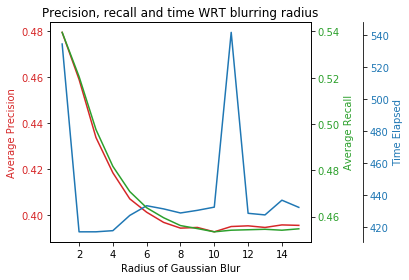

<Figure size 6000x2000 with 0 Axes>

The unit of 'Time elapsed' is second.


In [10]:
#Plotting the data
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_title('Precision, recall and time WRT blurring radius')
ax1.set_xlabel('Radius of Gaussian Blur')
ax1.set_ylabel('Average Precision', color=color)
ax1.plot(df2['blur_radius'], df2['AP1'], color=color) #Similarly, only AP1 is plotted
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Time Elapsed', color=color)
ax2.plot(df2['blur_radius'], df2['time_elapsed'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines["right"].set_position(("axes", 1.2))
ax3 = ax1.twinx()
color = 'tab:green'
ax3.set_ylabel('Average Recall', color=color)
ax3.plot(df2['blur_radius'], df2['AR1'], color=color) #Only AR1 is plotted
ax3.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.figure(figsize=[30,10],dpi=200)
plt.show()

print('The unit of \'Time elapsed\' is second.')

### Next Step: Run face detection model on blurred datasets

After the datasets being blurred with different `radius`, run the face detection model again to see how many faces it still can detect.

The face detection model uses value of 2 on `number_of_times_to_upsample`.

`radius`: ranging from 1 to 15

The result data is located in folder 'step4'

In [11]:
col_info_3 = ['radius', 'time_elapsed', 'face_detected']
df3 = pd.DataFrame(columns=col_info_3)
for i in range(1,16):
    filename = './step4/time_report_upsample_2_radius_%s.json' % str(i)
    with open(filename) as f:
        data = f.readline()
        data = data.split('.\\n')

        time_elapsed = float((data[0].split())[-1])
        face_detected = float(data[1].split('"')[0].split()[-1])
        
        df3 = df3.append(pd.Series([i, time_elapsed, face_detected], index=df3.columns), ignore_index=True)

df3

,radius,time_elapsed,face_detected
0,1.0,347.115346,1788.0
1,2.0,345.804269,1043.0
2,3.0,347.274081,689.0
3,4.0,346.802418,465.0
4,5.0,346.321708,328.0
5,6.0,347.754167,228.0
6,7.0,348.488556,172.0
7,8.0,346.481029,137.0
8,9.0,366.334584,112.0
9,10.0,360.487055,84.0


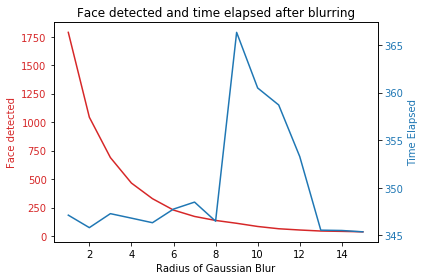

<Figure size 6000x2000 with 0 Axes>

The unit of 'Time elapsed' is second.


In [12]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_title('Face detected and time elapsed after blurring')
ax1.set_xlabel('Radius of Gaussian Blur')
ax1.set_ylabel('Face detected', color=color)
ax1.plot(df3['radius'], df3['face_detected'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Time Elapsed', color=color)
ax2.plot(df3['radius'], df3['time_elapsed'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.figure(figsize=[30,10],dpi=200)
plt.show()

print('The unit of \'Time elapsed\' is second.')